# Search of correlation between data story quality and SPARQL proficiency

In [13]:
import json
import pandas as pd

## Data Story quality
Computes a quality score for a single data story based on:
1. Text ratio in a target range (40%-60%).
2. No more than 3 consecutive chart-like components.

In [14]:
file_path = 'data_stories_summary.json'
with open(file_path, 'r') as file:
    data = json.load(file)

story_elements = {}

for story_id, story_data in data.items():
    story_elements[story_id] = story_data['elements_order']

df_quality = pd.DataFrame()

for story, elements in story_elements.items():
    temp_df = pd.DataFrame.from_dict(elements, orient='index', columns=[story])
    temp_df = temp_df.T
    df_quality = pd.concat([df_quality, temp_df], sort=False)
print(df_quality)

                 1           2         3           4           5           6  \
D-hp3wDV      text       count     count    data viz    data viz    data viz   
y4Srva15      text       count  data viz    data viz    data viz    data viz   
7qpfziir      text        text     count       count       count        text   
Nokx0yU6      text  textsearch  data viz    data viz         NaN         NaN   
gz_gxhYn      text       count     count       count        text    data viz   
U2OtB3XT      text        text     count        text       count        text   
v4h_GSI0      text       count  data viz    data viz        text    data viz   
1ptR3pru      text       count     count    data viz    data viz    data viz   
JQpdcw-d      text        text     count       count    data viz    data viz   
B9SLlUry      text       count     count    data viz    data viz    data viz   
r7i-PG2n      text        text     count       count        text    data viz   
AUmcnOzL      text       count      text

In [ ]:
def compute_quality_score(row,
                          text=['text'],
                          viz_types=['data viz'],
                          text_ratio_range=(0.40, 0.60),
                          weight_text=0.5,
                          weight_viz=0.5):
    components = row.dropna().tolist()
    if not components:
        return 0.0
    
    total = len(components)
    n_text = sum(1 for comp in components if comp in text)
    text_ratio = n_text / total

    #text
    if text_ratio <= 0.40:
        text_ratio_metric = 0.0
    elif text_ratio <= 0.60:
        text_ratio_metric = (text_ratio - 0.40) / (0.60 - 0.40)
    elif text_ratio <= 1.0:
        text_ratio_metric = (1.0 - text_ratio) / (1.0 - 0.60)
    else:
        # If somehow text_ratio exceeds 1.0, assign 0.
        text_ratio_metric = 0.0
    
    # data viz
    consecutive_count = 0
    excess_viz = 0

    for comp in components:
        if comp in viz_types:
            consecutive_count +=1
        else:
            # when a sequence of charts ends, count any excess beyond 3
            if consecutive_count > 3:
                excess_viz += (consecutive_count - 2)
            consecutive_count = 0
    if consecutive_count > 3:
        excess_viz += (consecutive_count - 2)

    repetitiveness_penalty = min(1.0, excess_viz/total)
    viz_repetitiveness_metric = 1.0 - repetitiveness_penalty
    # print(text_ratio_metric)
    # combine the two metrics
    quality_score = (weight_text * text_ratio_metric) + (weight_viz * viz_repetitiveness_metric)
    return round(quality_score, 2)

df_quality['quality_score'] = df_quality.apply(compute_quality_score, axis=1)
print(df_quality[['quality_score']])
df_quality[['quality_score']].to_csv('outputs/data_story_quality_score.csv')

          quality_score
D-hp3wDV           0.50
y4Srva15           0.36
7qpfziir           0.50
Nokx0yU6           0.50
gz_gxhYn           0.50
U2OtB3XT           0.68
v4h_GSI0           0.50
1ptR3pru           0.27
JQpdcw-d           0.52
B9SLlUry           0.35
r7i-PG2n           0.53
AUmcnOzL           0.50
tyK82z37           0.50
IRRbkmZk           0.50
Vy4_Rxzv           0.39
M9EZmoBI           0.50
uhDaBOl1           0.44
SXefpzf4           0.50
EzsIH_Et           0.38
16FP4tfG           0.36
sUMoEZI5           0.45
_HnVHPjm           0.50
4D206Lam           0.37
j3ZikN40           0.50
BOGODrvZ           0.52
abkhtH-r           0.27
Huo1mZpJ           0.70
JYOzBt8Y           0.33
buiNjeJj           0.39
PziKYGG_           0.55
wa1_2kB_           0.75
lkuzAhad           0.45
jamFJtUo           0.64
gzeEqkGo           0.35
KzqVF2Z6           0.29
Ww1HhAGH           0.98
IuSofTQ_           0.50
TQjKggI7           0.97
Jzaeaf75           0.50
SghkiaeU           0.31
R2GpYpI5        

## SPARQL Proficiency

### SPARQL Queries Working?

In [ ]:
import time
import re
import requests

# Define expected rules based on query type
expected_variables_by_type = {
    'table': None,  # No constraints on variable names, labels can be used
    'count': ['count'],  # Must have ?count of type number
    'barchart': ['label', 'count'],  # Option 1: ?label and ?count, Option 2: only ?label
    'linechart': ['label', 'count'],
    'doughnutchart': ['label', 'count'],
    'scatterplot': ['x', 'y'],  # Must have ?x and ?y
    'textsearch': None,  # No specific constraints, <<searchterm>> placeholder is normal
    'map': ['point', 'lat', 'long']  # Must have ?point, ?lat, and ?long
}

# Function to test the SPARQL query and validate based on type
def test_sparql_query(endpoint, query, default_search_term='"example_search_term"', max_retries=3, delay=30):
    headers = {
        'Accept': 'application/sparql-results+json'
    }

    # Replace the placeholder <<searchterm>> with the default search term
    query = query.replace("<<searchterm>>", default_search_term)

    params = {
        'query': query
    }
    
    retries = 0
    while retries < max_retries:
        try:
            response = requests.get(endpoint, headers=headers, params=params)
            
            # Check for any 2xx status code (successful responses)
            if 200 <= response.status_code < 300:
                print(f"Query to {endpoint} succeeded with status code {response.status_code}.")
                
                # Attempt to parse the JSON response
                try:
                    response_json = response.json()  # Ensure the response is valid JSON
                    return True, response_json
                except json.JSONDecodeError:
                    print(f"Failed to parse JSON for {query}. Response content: {response.text}")
                    return True, None  # Consider it a successful query but with invalid JSON
                
            elif response.status_code == 429:
                print(f'Rate limit hit (429). Retrying in {delay} seconds...')
                time.sleep(delay)
                retries += 1
            else:
                print(f'{response.status_code} for {endpoint}, {query}')
                return False, None
        except Exception as e:
            print(f'Exception for {endpoint}, {query}: {e}')
            return False, None
    return False, None

# Function to check for query correctness based on result variables and type-specific rules
def check_query_correctness(response_json, query_type):
    # If the response_json is None, we cannot validate the correctness
    if response_json is None:
        print(f"No valid JSON to check for query type {query_type}.")
        return False
    
    # Handling each type of query based on specific rules
    if query_type == 'table':
        print("Checking table query")
        return True
    
    elif query_type == 'count':
        print("Checking count query")
        if 'head' in response_json and 'vars' in response_json['head']:
            returned_vars = response_json['head']['vars']
            if 'count' in returned_vars:
                # Now check if the count is a number
                if 'results' in response_json and 'bindings' in response_json['results']:
                    for binding in response_json['results']['bindings']:
                        if 'count' in binding and binding['count']['type'] == 'literal' and binding['count'].get('datatype') == 'http://www.w3.org/2001/XMLSchema#integer':
                            return True
                print(f"Query did not return a valid number for ?count")
        return False

    elif query_type in ['barchart', 'linechart', 'doughnutchart']:
        print(f"Checking {query_type} query")
        if 'head' in response_json and 'vars' in response_json['head']:
            returned_vars = response_json['head']['vars']
            if ('label' in returned_vars and 'count' in returned_vars) or ('label' in returned_vars):
                return True
        return False
    
    elif query_type == 'scatterplot':
        print("Checking scatterplot query")
        if 'head' in response_json and 'vars' in response_json['head']:
            returned_vars = response_json['head']['vars']
            if 'x' in returned_vars and 'y' in returned_vars:
                return True
        return False

    elif query_type == 'textsearch':
        print("Checking textsearch query")
        return True  # Assume correctness as the search term is dynamically replaced
    
    elif query_type == 'map':
        print("Checking map query")
        if 'head' in response_json and 'vars' in response_json['head']:
            returned_vars = response_json['head']['vars']
            if 'point' in returned_vars and 'lat' in returned_vars and 'long' in returned_vars:
                return True
        return False

    else:
        print(f"Unrecognized query type: {query_type}")
        return False

file_path = 'data_stories_summary.json'
with open(file_path, 'r') as file:
    data = json.load(file)

story_sparql_metrics = []

# Iterate over the stories in the JSON
for story_id, story in data.items():
    sparql_endpoint = story['sparql_endpoint']
    queries = story.get('queries', [])

    total_queries = 0
    working_queries = 0
    correct_queries = 0

    for query_dict in queries:
        query = query_dict.get('query', '')
        query_type = query_dict.get('type', '')
        total_queries += 1
        query = re.sub(r'(^|\s)#.*?(\r\n|\n)', r'\1', query)
        query = re.sub(r'\s+', ' ', query).strip()

        success, response_json = test_sparql_query(sparql_endpoint, query)
        
        if success:
            working_queries += 1
            # Check query correctness based on response variables and result content
            if response_json:
                if check_query_correctness(response_json, query_type):
                    correct_queries += 1
        # Delay of 5 seconds between queries to avoid hitting rate limits
        time.sleep(5)

    # Calculate the percentage of working queries
    if total_queries > 0:
        working_percentage = (working_queries / total_queries) * 100
        correct_percentage = (correct_queries / total_queries) * 100
    else:
        working_percentage = 0
        correct_percentage = 0
    
    # composite SPARQL proficiency score (normalized to [0, 1]
    # proficiency_score = (working_percentage + correct_percentage) / 200.0
    story_sparql_metrics.append({
        'story_id': story_id,
        'total_queries': total_queries,
        'working_queries': working_queries,
        'correct_queries': correct_queries,
        'working_percentage': working_percentage,
        'correct_percentage': correct_percentage,
        # 'sparql_proficiency': round(proficiency_score, 2)
    })

    print(f"Story ID: {story_id} | Total: {total_queries} | Working: {working_queries} "
          f"({working_percentage:.2f}%) | Correct: {correct_queries} ({correct_percentage:.2f}%)")

df_sparql = pd.DataFrame(story_sparql_metrics)
df_sparql.to_csv('outputs/sparql_queries_score.csv')

In [ ]:
df_sparql_queries = pd.read_csv('outputs/sparql_queries_score.csv', index_col=0)
df_sparql_queries['combined_normalized'] = ((df_sparql_queries['working_percentage'] + df_sparql_queries['correct_percentage']) / 200.0).round(2)
df_sparql_queries['corret_normalized'] = (df_sparql_queries['correct_percentage'] / 100.0)

df_sparql_proficiency = df_sparql_queries[['story_id', 'combined_normalized', 'corret_normalized']].copy()
df_sparql_proficiency.to_csv('outputs/sparql_proficiency.csv')

### Federated bonus

The most difficult SPARQL feature deserves its own bonus.

In [ ]:
file_path = 'data_stories_summary.json'
with open(file_path, 'r') as file:
    data = json.load(file)
    
# Regular expression to capture all federated endpoints in SERVICE clauses
service_pattern = re.compile(r'SERVICE\s*<([^>]+)>', re.IGNORECASE)

# Initialize counters
federation_metrics = []
data_sources_list = []

# Loop through the stories in the JSON data (per story)
for story_id, story_data in data.items():
    queries = story_data.get('queries', [])
    
    main_endpoint = story_data.get("sparql_endpoint", "")
    if main_endpoint:
        data_sources_list.append(main_endpoint.split("//")[1])
    
    total_queries_story = 0
    federated_queries_story = 0
    
    # Loop through each query in the story
    for query_dict in queries:
        total_queries_story += 1
        query = query_dict.get('query', '')
        query = re.sub(r'(^|\s)#.*?(\r\n|\n)', r'\1', query)
        query = re.sub(r'\s+', ' ', query).strip()
        
        service_matches = service_pattern.findall(query)
        if service_matches:
            federated_queries_story += 1
    
    # Calculate federated bonus for this story (fraction of federated queries)
    federated_bonus = (federated_queries_story / total_queries_story) if total_queries_story > 0 else 0
    
    # Store per-story federation metrics (using story_id as key)
    federation_metrics.append({
        'story_id': story_id,
        'total_queries_story': total_queries_story,
        'federated_queries_story': federated_queries_story,
        'federated_bonus': federated_bonus
    })


df_federation = pd.DataFrame(federation_metrics)
print(df_federation[['story_id', 'federated_bonus']])
df_federation.to_csv('outputs/sparql_federation.csv')

    story_id  federated_bonus
0   D-hp3wDV         0.000000
1   y4Srva15         0.000000
2   7qpfziir         0.000000
3   Nokx0yU6         0.000000
4   gz_gxhYn         0.000000
5   U2OtB3XT         0.000000
6   v4h_GSI0         0.000000
7   1ptR3pru         0.000000
8   JQpdcw-d         0.000000
9   B9SLlUry         0.000000
10  r7i-PG2n         0.555556
11  AUmcnOzL         0.000000
12  tyK82z37         0.000000
13  IRRbkmZk         0.000000
14  Vy4_Rxzv         0.000000
15  M9EZmoBI         0.000000
16  uhDaBOl1         0.000000
17  SXefpzf4         0.000000
18  EzsIH_Et         0.000000
19  16FP4tfG         0.000000
20  sUMoEZI5         0.000000
21  _HnVHPjm         0.000000
22  4D206Lam         0.000000
23  j3ZikN40         0.000000
24  BOGODrvZ         0.800000
25  abkhtH-r         0.000000
26  Huo1mZpJ         0.000000
27  JYOzBt8Y         0.000000
28  buiNjeJj         0.000000
29  PziKYGG_         0.000000
30  wa1_2kB_         0.000000
31  lkuzAhad         0.000000
32  jamFJt

In [ ]:
df_proficiency = pd.read_csv("outputs/sparql_proficiency.csv", index_col=0)
df_federation = pd.read_csv("outputs/sparql_federation.csv", index_col=0)

df_merged = df_proficiency.merge(df_federation['federated_bonus'], left_index=True, right_index=True)

print(df_merged)
df_merged.to_csv("outputs/sparql_proficiency_updated.csv")

    story_id  combined_normalized  corret_normalized  federated_bonus
0   D-hp3wDV                 1.00           1.000000         0.000000
1   y4Srva15                 1.00           1.000000         0.000000
2   7qpfziir                 1.00           1.000000         0.000000
3   Nokx0yU6                 1.00           1.000000         0.000000
4   gz_gxhYn                 1.00           1.000000         0.000000
5   U2OtB3XT                 1.00           1.000000         0.000000
6   v4h_GSI0                 1.00           1.000000         0.000000
7   1ptR3pru                 1.00           1.000000         0.000000
8   JQpdcw-d                 1.00           1.000000         0.000000
9   B9SLlUry                 1.00           1.000000         0.000000
10  r7i-PG2n                 1.00           1.000000         0.555556
11  AUmcnOzL                 0.92           0.833333         0.000000
12  tyK82z37                 0.82           0.727273         0.000000
13  IRRbkmZk        

### SPARQL Features Complexity and Diversity

#### COMPLEXITY
How and why we should distribute weights:

| Feature      | Score | Explanation |
| ----------- | ------- | ----------- |
| FILTER      | 0.2      | The most intuitive, but not trivial |
| LIMIT      | 0.2      | Basic usage, but unfamiliar term for some |
| OFFSET      | 0.3      | Adds complexity to pagination |
| DISTINCT      | 0.3      | Requires understanding of duplicate bindings |
| OPTIONAL    | 0.5      | Key concept, but hard to grasp implications |
| BIND     | 0.5      | Computation and variable assignment add load |
| COUNT      | 0.5      | Aggregation logic is a new concept for many (Even though there is documentation, it's not mandatory) |
| UNION      | 0.5      | Syntax and conceptual branching |
| MINUS      | 0.7      | Negative logic can be confusing |
| FROM      | 0.7      | Requires deeper knowledge of datasets |

#### DIVERSITY

For each query:
1. Count how many different features were used (feature appeared at least once).
2. Divide that number by 10 (because you are analyzing 10 possible features).

Then:
3. Sum all diversity scores across queries.
4. Divide by total number of queries → gives the average diversity for the story.

NB: THE ABOVE WAS BEFORE I RECONSIDERED ALL THE FEATURES.
WHY?
Because:
1. I noticed and error when searching for them (I was not doing `re.IGNORECASE`)
2. I noticed that I missed some important features such as `ORDER BY` and `GROUP BY`, and including `FROM` that nobody used.

So I decided to broaden the inclusion of features. The following is an updated analysis. This leads to have another file for SPARQL proficiency called `sparql_proficiency_new.csv`

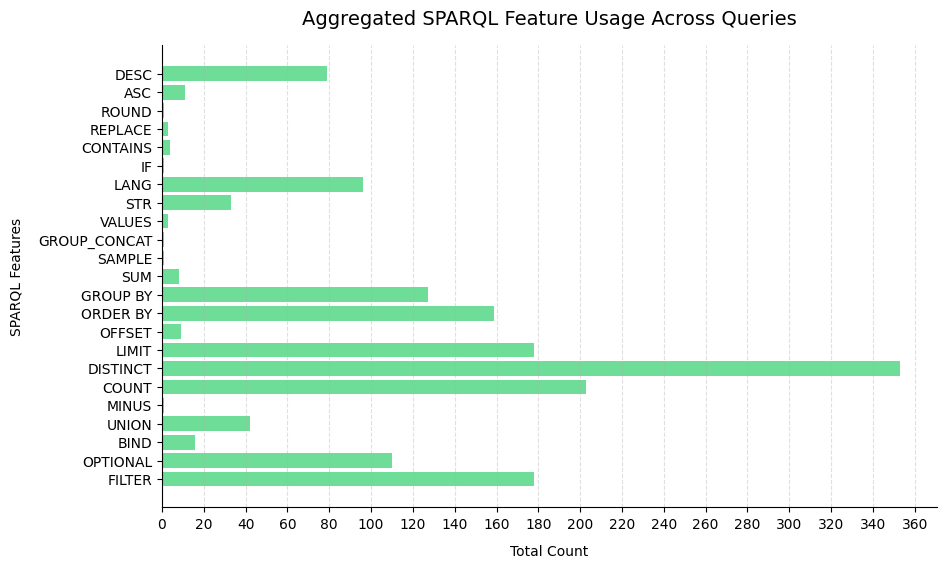

In [ ]:
import matplotlib.pyplot as plt
color_palette = ['#5565cf', '#b14ecf', '#cf4773', '#cf913f', '#87cf38', '#30cf6b', '#29a1cf', '#2138cf']

file_path = 'data_stories_summary.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# List of SPARQL features to look for
sparql_features = ["FILTER", "OPTIONAL", "BIND", "UNION", "MINUS", "COUNT", 
                   "DISTINCT", "LIMIT", "OFFSET", "ORDER BY", "GROUP BY", "SUM", "SAMPLE", 
                   "GROUP_CONCAT", "VALUES", "STR", "LANG", "IF", "CONTAINS", "REPLACE", "ROUND", "ASC", "DESC"]


def clean_query_text(query):
    # Remove comments
    query = re.sub(r'(^|\s)#.*?(\r\n|\n)', r'\1', query)
    # Normalize whitespace
    query = re.sub(r'\s+', ' ', query)
    # Remove variables like ?varName
    query = re.sub(r'\?[^\s\)\(]*', '', query)
    # Remove URIs like <http://example.org/prop>
    query = re.sub(r'<[^>]*>', '', query)
    return query.strip()

# Function to count features in a query
def count_sparql_features(query, features):
    query = clean_query_text(query)
    feature_counts = {
        feature: len(re.findall(r'\b' + re.escape(feature) + r'\b', query, re.IGNORECASE))
        for feature in features
    }
    return feature_counts

# Dictionary to accumulate feature counts across all queries
total_feature_counts = {feature: 0 for feature in sparql_features}

# To store detailed counts per story (optional, for further analysis)
story_feature_counts = {}

# Loop through each story and its queries
for story_id, story_data in data.items():
    story_queries = story_data.get('queries', [])
    story_counts = {feature: 0 for feature in sparql_features}
    
    for query_dict in story_queries:
        query = query_dict.get('query', '')
        if query:
            feature_counts = count_sparql_features(query, sparql_features)
            for feature, count in feature_counts.items():
                total_feature_counts[feature] += count
                story_counts[feature] += count
    
    # Save per-story counts
    story_feature_counts[story_id] = story_counts


plt.figure(figsize=(10, 6))
plt.barh(list(total_feature_counts.keys()), list(total_feature_counts.values()), color=color_palette[5], alpha=0.7)
plt.title('Aggregated SPARQL Feature Usage Across Queries',  fontsize=14, pad=15)
plt.xlabel('Total Count', labelpad=10)
plt.ylabel('SPARQL Features', labelpad=10)
plt.grid(axis='x', linestyle='--', alpha=0.4)
max_val = max(total_feature_counts.values())
plt.xticks(np.arange(0, max_val + 20, 20))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [ ]:
import re
import json
import pandas as pd

sparql_features = ["FILTER", "OPTIONAL", "BIND", "UNION", "MINUS", "COUNT", 
                   "DISTINCT", "LIMIT", "OFFSET", "ORDER BY", "GROUP BY", "SUM", "SAMPLE", 
                   "GROUP_CONCAT", "VALUES", "STR", "LANG", "IF", "CONTAINS", "REPLACE", "ROUND", "ASC", "DESC"]
# feature_weights = {
#     "FILTER": 0.2,
#     "OPTIONAL": 0.5,
#     "BIND": 0.5,
#     "UNION": 0.5,
#     "MINUS": 0.7,
#     "COUNT": 0.5,
#     "DISTINCT": 0.3,
#     # "FROM": 0.7,
#     "LIMIT": 0.2,
#     "OFFSET": 0.3
# }

feature_weights = {
    # Basic filtering and limiting
    "FILTER": 0.1,
    "DISTINCT": 0.2,
    "LIMIT": 0.1,
    "OFFSET": 0.1,
    "ASC": 0.1,
    "DESC": 0.1,

    # Control-flow / branching
    "OPTIONAL": 0.5,
    "UNION": 0.5,
    "MINUS": 0.7,
    "BIND": 0.5,

    # Aggregation and grouping
    "COUNT": 0.5,
    "SUM": 0.5,
    "SAMPLE": 0.5,
    "GROUP_CONCAT": 0.7,
    "ORDER BY": 0.5,
    "GROUP BY": 0.5,

    # Functions and value expressions
    "VALUES": 0.2,
    "STR": 0.2,
    "LANG": 0.2,
    "IF": 0.5,
    "CONTAINS": 0.5,
    "REPLACE": 0.5,
    "ROUND": 0.2,
}

def count_sparql_features(query, features):
    """
    Count the occurrences of each feature in the query using regex word boundaries.
    Returns a dictionary with the counts.
    """
    feature_counts = {feature: len(re.findall(r'\b' + feature + r'\b', query, re.IGNORECASE)) 
                      for feature in features}
    return feature_counts

# Dictionary to store per-story metrics for the simple average metric.
story_feature_metrics = {}

file_path = 'data_stories_summary.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Loop through each story and calculate the average number of SPARQL features per query.
for story_id, story_data in data.items():
    queries = story_data.get('queries', [])
    total_queries = len(queries)
    total_feature_counts = {feature: 0 for feature in sparql_features}
    diversity_sum = 0.0
    
    for query_dict in queries:
        query = query_dict.get('query', '')
        query = re.sub(r'(^|\s)#.*?(\r\n|\n)', r'\1', query)
        query = re.sub(r'\s+', ' ', query).strip()
        # Count features for this query.
        feature_counts = count_sparql_features(query, sparql_features)
        for feature, count in feature_counts.items():
            total_feature_counts[feature] += count

        # Calculate diversity for this query
        total_features_in_query = sum(feature_counts.values())
        unique_features_in_query = sum(1 for count in feature_counts.values() if count > 0)
        diversity_score = unique_features_in_query / len(sparql_features)

        diversity_sum += diversity_score
        
    weighted_sum = sum(total_feature_counts[feature] * feature_weights.get(feature, 1) for feature in sparql_features)
    # Compute the simple average metric: total features divided by number of queries.
    feature_metric = weighted_sum / total_queries if total_queries > 0 else 0.0
    
    # Calculate average diversity metric
    diversity_metric = diversity_sum / total_queries if total_queries > 0 else 0.0
    
    # Store the metrics for the story using its story_id.
    story_feature_metrics[story_id] = {
        'total_queries': total_queries,
        'weighted_feature_sum': weighted_sum,
        'sparql_feature_metric': feature_metric,
        'diversity_metric': diversity_metric
    }

# Convert the metrics dictionary into a DataFrame.
df_features = pd.DataFrame.from_dict(story_feature_metrics, orient='index')
df_features.index.name = 'story_id'
df_features.reset_index(inplace=True)

# Normalize the sparql_feature_metric using min-max normalization
min_metric = df_features['sparql_feature_metric'].min()
max_metric = df_features['sparql_feature_metric'].max()

if max_metric > min_metric:
    df_features['normalized_sparql_feature_metric'] = (
        (df_features['sparql_feature_metric'] - min_metric) / (max_metric - min_metric)
    )
else:
    df_features['normalized_sparql_feature_metric'] = 0

print(df_features[['story_id', 'sparql_feature_metric', 'normalized_sparql_feature_metric', 'diversity_metric']])
df_features.to_csv('outputs/sparql_features.csv')

    story_id  sparql_feature_metric  normalized_sparql_feature_metric  \
0   D-hp3wDV               1.837500                          0.635359   
1   y4Srva15               1.180000                          0.344751   
2   7qpfziir               1.463636                          0.470116   
3   Nokx0yU6               0.900000                          0.220994   
4   gz_gxhYn               1.445455                          0.462079   
5   U2OtB3XT               1.550000                          0.508287   
6   v4h_GSI0               1.275000                          0.386740   
7   1ptR3pru               1.188889                          0.348680   
8   JQpdcw-d               1.208333                          0.357274   
9   B9SLlUry               1.600000                          0.530387   
10  r7i-PG2n               2.322222                          0.849601   
11  AUmcnOzL               2.150000                          0.773481   
12  tyK82z37               1.109091                

In [ ]:
df_proficiency = pd.read_csv("outputs/sparql_proficiency_updated.csv", index_col=0)
df_features = pd.read_csv("outputs/sparql_features.csv", index_col=0)

df_merged = df_proficiency.merge(df_features[['normalized_sparql_feature_metric', 'diversity_metric']], left_index=True, right_index=True)
print(df_merged)
df_merged.to_csv("outputs/sparql_proficiency_updated_two.csv")

    story_id  combined_normalized  corret_normalized  federated_bonus  \
0   D-hp3wDV                 1.00           1.000000         0.000000   
1   y4Srva15                 1.00           1.000000         0.000000   
2   7qpfziir                 1.00           1.000000         0.000000   
3   Nokx0yU6                 1.00           1.000000         0.000000   
4   gz_gxhYn                 1.00           1.000000         0.000000   
5   U2OtB3XT                 1.00           1.000000         0.000000   
6   v4h_GSI0                 1.00           1.000000         0.000000   
7   1ptR3pru                 1.00           1.000000         0.000000   
8   JQpdcw-d                 1.00           1.000000         0.000000   
9   B9SLlUry                 1.00           1.000000         0.000000   
10  r7i-PG2n                 1.00           1.000000         0.555556   
11  AUmcnOzL                 0.92           0.833333         0.000000   
12  tyK82z37                 0.82           0.72727

### Final Proficiency Values

In [ ]:
def compute_sparql_proficiency(row):
    """
    Compute the composite SPARQL proficiency score using:
      - normalized working/correct percentage
      - federated bonus
      - SPARQL feature metric
      sparql_proficiency = normalized_wc * 0.5 + federated_bonus * 0.2 + sparql_feature_metric * 0.3
    """

    weight_wc = 0.1      # working/correct queries, we already know that most of them works (prev 0.2)
    weight_fed = 0.1     # shows advanced usage with federated queries (prev 0.3)
    weight_feat = 0.4    # features usage reflects query complexity and versatility (prev 0.5)
    weigh_diversity = 0.4
    
    proficiency = (row['corret_normalized'] * weight_wc +
                   row['federated_bonus'] * weight_fed +
                   row['normalized_sparql_feature_metric'] * weight_feat +
                   row['diversity_metric'] * weigh_diversity)
    
    return proficiency

df_proficiency_final = pd.read_csv("outputs/sparql_proficiency_updated_two.csv", index_col=0)
df_proficiency_final['sparql_proficiency'] = df_proficiency_final.apply(compute_sparql_proficiency, axis=1)

print(df_proficiency_final[['story_id', 'sparql_proficiency']])
df_proficiency_final.to_csv("outputs/sparql_proficiency_new.csv")

    story_id  sparql_proficiency
0   D-hp3wDV            0.419361
1   y4Srva15            0.293553
2   7qpfziir            0.344963
3   Nokx0yU6            0.228978
4   gz_gxhYn            0.337006
5   U2OtB3XT            0.366358
6   v4h_GSI0            0.311218
7   1ptR3pru            0.289714
8   JQpdcw-d            0.280591
9   B9SLlUry            0.375198
10  r7i-PG2n            0.576555
11  AUmcnOzL            0.470986
12  tyK82z37            0.243941
13  IRRbkmZk            0.312014
14  Vy4_Rxzv            0.422130
15  M9EZmoBI            0.226322
16  uhDaBOl1            0.182971
17  SXefpzf4            0.196733
18  EzsIH_Et            0.250921
19  16FP4tfG            0.318246
20  sUMoEZI5            0.169628
21  _HnVHPjm            0.128986
22  4D206Lam            0.310680
23  j3ZikN40            0.477190
24  BOGODrvZ            0.536398
25  abkhtH-r            0.330795
26  Huo1mZpJ            0.316717
27  JYOzBt8Y            0.373926
28  buiNjeJj            0.284591
29  PziKYG

## Correlation Analysis

In [4]:
df_data_story = pd.read_csv('data_story_quality_score.csv', index_col=0)
df_data_story = df_data_story.reset_index().rename(columns={'index': 'story_id'})

df_sparql = pd.read_csv('sparql_proficiency_new.csv', index_col=0)

df_combined = pd.merge(df_data_story[['story_id', 'quality_score']],
                       df_sparql[['story_id', 'sparql_proficiency']],
                       on='story_id', how='inner')

print(df_combined)
df_combined.to_csv('scores_for_correlation.csv')

    story_id  quality_score  sparql_proficiency
0   D-hp3wDV           0.50            0.368823
1   y4Srva15           0.36            0.276373
2   7qpfziir           0.50            0.312257
3   Nokx0yU6           0.50            0.211592
4   gz_gxhYn           0.50            0.300251
5   U2OtB3XT           0.68            0.328369
6   v4h_GSI0           0.50            0.298547
7   1ptR3pru           0.27            0.265637
8   JQpdcw-d           0.52            0.244200
9   B9SLlUry           0.35            0.340020
10  r7i-PG2n           0.53            0.526683
11  AUmcnOzL           0.50            0.414576
12  tyK82z37           0.50            0.242445
13  IRRbkmZk           0.50            0.290530
14  Vy4_Rxzv           0.39            0.380067
15  M9EZmoBI           0.50            0.205242
16  uhDaBOl1           0.44            0.174389
17  SXefpzf4           0.50            0.182585
18  EzsIH_Et           0.38            0.227935
19  16FP4tfG           0.36            0

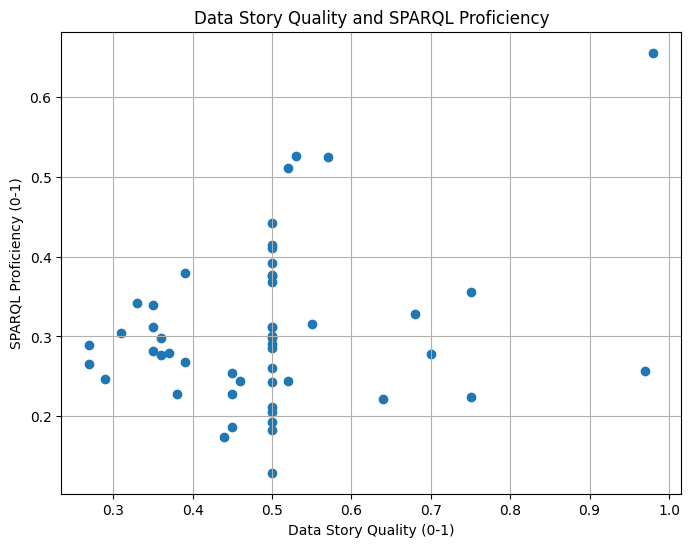

In [5]:
import matplotlib.pyplot as plt
import numpy as np

df_combined = pd.read_csv('scores_for_correlation.csv', index_col=0)

plt.figure(figsize=(8, 6))
plt.scatter(df_combined['quality_score'], df_combined['sparql_proficiency'])
plt.xlabel("Data Story Quality (0-1)")
plt.ylabel("SPARQL Proficiency (0-1)")
plt.title("Data Story Quality and SPARQL Proficiency")
plt.grid(True)
plt.show()

In [6]:
# Pearson
correlation = df_combined['quality_score'].corr(df_combined['sparql_proficiency'])
print("Pearson correlation coefficient:", correlation)

Pearson correlation coefficient: 0.278987871828632


In [7]:
# Spearman 
spearman_corr = df_combined['quality_score'].corr(df_combined['sparql_proficiency'], method='spearman')
print("Spearman correlation coefficient:", spearman_corr)

Spearman correlation coefficient: 0.18012906461903466


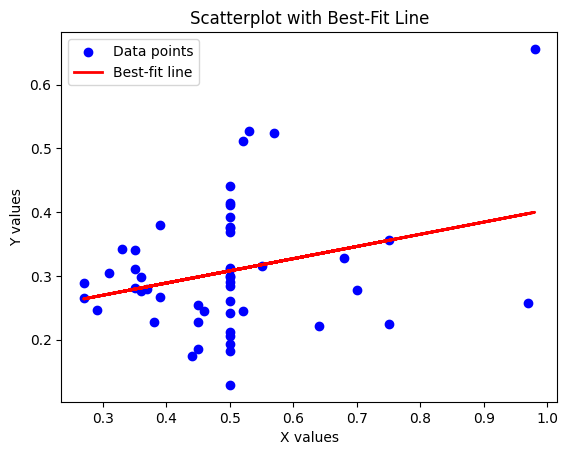

In [8]:
import numpy as np
import matplotlib.pyplot as plt
 
# Sample data
x = np.array(df_combined['quality_score'])
y = np.array(df_combined['sparql_proficiency'])
 
# Compute best-fit line (linear regression)
m, b = np.polyfit(x, y, 1)  # 1st-degree polynomial (y = mx + b)
 
# Create scatter plot
plt.scatter(x, y, color='blue', label="Data points")
 
# Plot best-fit line
plt.plot(x, m*x + b, color='red', linewidth=2, label="Best-fit line")
 
# Labels and title
plt.xlabel("X values")
plt.ylabel("Y values")
plt.title("Scatterplot with Best-Fit Line")
plt.legend()
plt.show()